# Sketching AutoEncoder with a Catmull-Rom Spline

This notebook demonstrates an autoencoder that predicts both a list of 2d points describing a Catmull-Rom spline. Curves between each possible pair of points (excluding the first an last points which act purely as control points) are drawn into separate rasters before being merged into a single image with a compositing function. Only the encoder network has learnable parameters; the decoder is entirely deterministic, but differentiable.

The network is defined below; the number of points can be configured.

In [1]:
import torch
import torch.nn as nn
try:
    from dsketch.raster.disttrans import catmull_rom_spline, curve_edt2_bruteforce
    from dsketch.raster.raster import exp
    from dsketch.raster.composite import softor
except:
    !pip install git+https://github.com/jonhare/DifferentiableSketching.git
    from dsketch.raster.disttrans import catmull_rom_spline, curve_edt2_bruteforce
    from dsketch.raster.raster import exp
    from dsketch.raster.composite import softor
    
    
class AE(nn.Module):
    def __init__(self, npoints=16, hidden=64, sz=28):
        super(AE, self).__init__()

        # build the coordinate grid:
        r = torch.linspace(-1, 1, sz)
        c = torch.linspace(-1, 1, sz)
        grid = torch.meshgrid(r, c)
        grid = torch.stack(grid, dim=2)
        self.register_buffer("grid", grid)

        # this is a list of quads of "connections" 0-1-2-3, 1-2-3-4, 2-3-4-5, ...
        self.coordpairs = torch.stack([torch.arange(0, npoints-3, 1),
                                       torch.arange(1, npoints-2, 1),
                                       torch.arange(2, npoints-1, 1),
                                       torch.arange(3, npoints, 1)], dim=1)

        self.enc = nn.Sequential(
            nn.Linear(sz**2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, npoints*2),
            nn.Tanh()
        )

    def forward(self, inp, sigma=7e-3):
        # the encoding process will flatten the input and
        # push it through the encoder networks
        bs = inp.shape[0]
        x = inp.view(bs, -1)
        pts = self.enc(x) #[batch, npoints*2]
        pts = pts.view(bs, -1, 2) # expand -> [batch, npoints, 2]

        # compute all valid permuations of line start and end points
        lines = torch.cat((pts[:,self.coordpairs[:,0]],
                           pts[:,self.coordpairs[:,1]],
                           pts[:,self.coordpairs[:,2]],
                           pts[:,self.coordpairs[:,3]]), dim=-1) #[batch, nlines, 8]

        lines = lines.view(-1, 4, 2) # flatten -> [batch * nlines, 4, 2]

        # Rasterisation steps
        # draw the lines (for every input in the batch)
        rasters = exp(curve_edt2_bruteforce(lines, self.grid, 2, 10, cfcn=catmull_rom_spline), sigma) # -> [batch * nlines, 28, 28]
        rasters = rasters.view(bs, -1, rasters.shape[-2], rasters.shape[-1]) # then reshape back to images [batch, nlines, rows, cols]

        # composite
        return softor(rasters)

We'll do a simple test on MNIST and try and train the AE to be able to reconstruct digit images (and of course at the same time perform image vectorisation/autotracing of polylines). Hyperparameters are pretty arbitrary (defaults for Adam; 256 batch size) and the line width is fixed to a value that works well for MNIST.

In [2]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
import torchvision

batch_size = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(28, 28))
    ])
trainset = torchvision.datasets.MNIST('/tmp', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST('/tmp', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AE(npoints=16).to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
    for images, classes in trainloader:
        images = images.to(device)
        opt.zero_grad()
        out = model(images)
        loss = nn.functional.mse_loss(out, images)
        loss.backward()
        opt.step()

    print(loss)

tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward>)


Finally here's a visualisation of a set of test inputs and their rendered reconstructions:

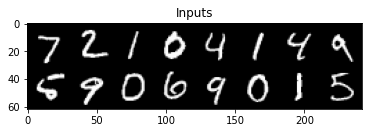

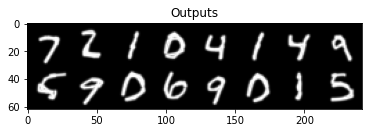

In [3]:
batch = iter(testloader).next()[0][0:64]
out = model(batch.to(device))

plt.figure()
inputs = torchvision.utils.make_grid(batch.unsqueeze(1))
plt.title("Inputs")
plt.imshow(inputs.permute(1,2,0))

plt.figure()
outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
plt.title("Outputs")
plt.imshow(outputs.permute(1,2,0))